In [3]:
import numpy as np
import pandas as pd 
import pyro
import torch 
from torch.distributions import constraints
import pyro.distributions as dist 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from pyro import optim
from pyro.infer import SVI, Trace_ELBO
from npsde_pyro import NPSDE, Kernel
from copy import deepcopy
# from npde import NPSDE
# from npde_helper import load_model, save_model, build_model, fit_model
# from utils import gen_data

In [19]:
# Learn Pyro 


def model_make(prior, obs1):

    def model():
        latent_var = pyro.sample('z1', prior)
        if latent_var.item() > 0.5:
            obs_var = pyro.sample('obs1', dist.Normal(1,1), obs=obs1) 
        else:
            obs_var = pyro.sample('obs1', dist.Normal(-1,1), obs=obs1) 

        return latent_var.item(), obs_var.item() 
    
    return model 

def guide():
    a = pyro.param('a', torch.tensor(0.0))
    b = pyro.param('b', torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample('z1', dist.Normal(a,b))


pyro.clear_param_store() 
svi = pyro.infer.SVI(model=model_make(dist.Normal(1.5,1),torch.tensor(1.0)), guide=guide, optim=pyro.optim.Adam({"lr":0.03}), loss=pyro.infer.Trace_ELBO())

for _ in range(10000):
    svi.step() 
print("Prior distribution: Normal(1.5,1)")
print('a= ', pyro.param('a').item())
print('b= ', pyro.param('b').item())

pyro.clear_param_store() 
svi = pyro.infer.SVI(model=model_make(dist.Normal(3,1),torch.tensor(1.0)), guide=guide, optim=pyro.optim.Adam({"lr":0.03}), loss=pyro.infer.Trace_ELBO())

for _ in range(10000):
    svi.step() 
print("Prior distribution: Normal(3,1)")
print('a= ', pyro.param('a').item())
print('b= ', pyro.param('b').item())


In [4]:

# Assume start and end point are completely filled 
def model(npsde, snippet, n_segments=5):
    start_t, start_point = snippet[0,0], snippet[0,1:] 
    end_t, end_point = snippet[-1,0], snippet[-1,1:]

    assert(n_segments % (end_t - start_t) == 0) # must have integer number of blocks between each timestep 
    s = int(n_segments / (end_t - start_t))
    n_dims = snippet.shape[1] - 1
    delta_t = (end_t - start_t) / n_segments
    linear_interpolation = np.array([np.linspace(start_point[i], end_point[i], n_segments+1) for i in range(n_dims)]).T 
    snippet_data = np.empty(linear_interpolation.shape)
    snippet_data[:] = np.nan
    for i in range(snippet.shape[0]):
        snippet_data[s * int(snippet[i,0]), :] = snippet[i,1:]
    # add constraints to known values 
    linear_interpolation[~np.isnan(snippet_data)] = snippet_data[~np.isnan(snippet_data)]

    nodes = pyro.sample('nodes', dist.Normal(torch.tensor(linear_interpolation, dtype=torch.float32), torch.ones(linear_interpolation.shape)).to_event(1).to_event(1))
    
    fs, gs = npsde.fgAt(nodes[:-1, :])
    # fs = npsde.f(nodes[:-1, :].detach().numpy())
    # gs = npsde.diffus.g(nodes[:-1, :].detach().numpy(), None)

    for i in range(n_segments):
        drift = fs[i,:]
        diffusion = gs[i,:]
        # Assume on-diagonal 
        covariance = torch.diag(diffusion)

        # Brownian bridge test
        # t1 = delta_t * (i + 1)
        # t2 = delta_t * (n_segments - i - 1)
        # BB_mean = (start_point * t2 + end_point * t1) / (t1 + t2)
        # BB_variance = t1 * t2 / (t1 + t2) + 0.0001
        # pyro.sample('node_{}'.format(i+1), dist.MultivariateNormal(torch.tensor(BB_mean,dtype=torch.float32), torch.diag(torch.tensor([BB_variance] * n_dims, dtype=torch.float32))), obs=nodes[i+1])

        pyro.sample('node_{}'.format(i+1), dist.MultivariateNormal(drift * delta_t, covariance * delta_t), obs=nodes[i+1])


def guide(npsde, snippet, n_segments=5):
    start_t, start_point = snippet[0,0], snippet[0,1:] 
    end_t, end_point = snippet[-1,0], snippet[-1,1:]

    assert(n_segments % (end_t - start_t) == 0) # must have integer number of blocks between each timestep 
    s = int(n_segments / (end_t - start_t))
    n_dims = snippet.shape[1] - 1
    delta_t = (end_t - start_t) / n_segments
    linear_interpolation = np.array([np.linspace(start_point[i], end_point[i], n_segments+1) for i in range(n_dims)]).T 
    snippet_data = np.empty(linear_interpolation.shape)
    snippet_data[:] = np.nan
    for i in range(snippet.shape[0]):
        snippet_data[s * int(snippet[i,0]), :] = snippet[i,1:]

    # add constraints to known values 
    linear_interpolation[~np.isnan(snippet_data)] = np.nan # snippet[*~np.isnan(snippet)]
    linear_interpolation_flat = np.ravel(linear_interpolation)
    nodes_q_init =  torch.tensor(linear_interpolation_flat[~np.isnan(linear_interpolation_flat)], dtype=torch.float32) # +torch.randn(n_segments-1, n_dims)*.75
    nodes_q = pyro.param("nodes_q", nodes_q_init)
    snippet_tensor = torch.tensor(snippet_data[~np.isnan(snippet_data)], dtype=torch.float32)
    # torch.cat(
    #     (torch.tensor(np.atleast_2d(linear_interpolation[0,:]), dtype=torch.float32), 
    #     nodes_q, 
    #     torch.tensor(np.atleast_2d(linear_interpolation[-1,:]), dtype=torch.float32)))
    combined = torch.zeros(linear_interpolation_flat.shape)
    tensor_filter = torch.tensor(~np.isnan(linear_interpolation_flat))
    combined[tensor_filter] = nodes_q
    combined[~tensor_filter] = snippet_tensor
    nodes = pyro.sample('nodes', dist.Delta(combined.reshape(linear_interpolation.shape)).to_event(1).to_event(1))
    return combined.reshape(linear_interpolation.shape) 


In [ ]:

def plot(self, snippet, nodes, margin=0.2, comparison=None, fname=None):

    with torch.no_grad():
        Z = self.Z.detach() 
        Zg = self.Zg.detach() 
        U = pyro.get_param_store().get_param('U_map').detach() 
        Ug = pyro.get_param_store().get_param('Ug_map').detach() 
        sf_f = self.sf_f if self.fix_sf else pyro.param('sf_f', self.sf_f).detach() 
        sf_g = self.sf_g if self.fix_sf else pyro.param('sf_g', self.sf_g).detach() 
        ell_f = self.ell_f if self.fix_ell else pyro.param('ell_f', self.ell_f).detach() 
        ell_g = self.ell_g if self.fix_ell else pyro.param('ell_g', self.ell_g).detach() 
        kernel_f = Kernel(sf_f, ell_f)
        kernel_g = Kernel(sf_g, ell_g)

    start = snippet[0, 1:]
    end = snippet[-1,1:]
    dist = end - start 
    

    extents = [min(nodes[:,0].tolist() + [start[0], end[0]]) , max(nodes[:,0].tolist() + [start[0], end[0]]) ,
    min(nodes[:,1].tolist()+ [start[1], end[1]]) , max(nodes[:,1].tolist()+[start[1], end[1]])]
    
    
    W = 10
    # Fixed boundaries
    xv = np.linspace(extents[0], extents[1], W)
    yv = np.linspace(extents[2], extents[3], W)
    xvv,yvv = np.meshgrid(xv,yv, indexing='ij')


    Zs = np.array([xvv.T.flatten(),yvv.T.flatten()], dtype=np.float32).T

    U = self.unwhiten_U(U, Z, kernel_f)
    Ug = self.unwhiten_U(Ug, Zg, kernel_g)

    f,g = self.calc_drift_diffusion(Zs, U, Ug, Z, Zg, kernel_f, kernel_g)

    Us = f.detach().numpy()
    Ugs = g.detach().numpy()

    fig = plt.figure(2, figsize=(15,12))
    gs = mpl.gridspec.GridSpec(nrows=10, ncols=10)
    ax1 = plt.subplot(gs[0:10,0:10])
    # ax2 = plt.subplot(gs[0:10,11])
    # ax3 = plt.subplot(gs[11,0:10])
    Uc = np.sqrt(Us[:,0] ** 2 + Us[:,1] ** 2)
    strm = ax1.streamplot(np.unique(list(Zs[:,0])), np.unique(list(Zs[:,1])), Us[:,0].reshape(W,W), Us[:,1].reshape(W,W), color=Uc.reshape(W,W), cmap='autumn')
    ax1.set_title('MAP Path')


    Ugs = Ugs.reshape(W, W, 2) 
    mag = (Ugs[:,:,0] ** 2 + Ugs[:,:,1] ** 2) ** 0.5
    x_max, y_max, mag_max, mag_min = Ugs[:,:,0].max(), Ugs[:,:,1].max() , mag.max(), mag.min()
    x_delta, y_delta = (extents[1] - extents[0]) / W, (extents[3] - extents[2]) / W

    Zs_grid = Zs.reshape(W, W, 2)
    ellipses = [] 
    cmap = mpl.cm.get_cmap('viridis')
    for r in range(W):
        for c in range(W):
            ellipses += [ax1.add_patch(mpl.patches.Ellipse(Zs_grid[r, c], np.sqrt(Ugs[r,c,0]/x_max)*(x_delta), np.sqrt(Ugs[r,c,1]/y_max)*(y_delta), color=cmap(((Ugs[r,c,0] ** 2 + Ugs[r,c,1] ** 2) ** 0.5 - mag_min) / (mag_max - mag_min))))]


    midpoints = np.add(nodes[:-1,:], nodes[1:,:]) /2 
    directions = (nodes[1:,:] - nodes[:-1,:]) 
    directions /= np.linalg.norm(directions)
    ax1.plot(nodes[:,0], nodes[:,1], '-ko', label='MAP path')
    if comparison is not None:
        ax1.plot(comparison[:,0], comparison[:,1], '-bo', label='Known path')
        delta_t = (snippet[0,0] - snippet[-1,0]) / (len(nodes)-1)
        forward = np.mean(self.forward(nodes[0,:],np.float32(delta_t), len(nodes)-1, 50),axis=0)
        ax1.plot(forward[:,0], forward[:,1], marker='o', color='lime', label='MC path')

        ax1.plot()
    ax1.quiver(midpoints[:,0], midpoints[:,1], directions[:,0], directions[:,1], angles='xy', units='height',width=0.002, headwidth=6, headlength=10)
    ax1.scatter([start[0], end[0]], [start[1], end[1]], marker='*', c='#00ff00', s=100, zorder=3)

    ax1.legend()
    # mpl.colorbar.ColorbarBase(ax3, cmap = cmap, norm = mpl.colors.Normalize(vmin=mag_min, vmax=mag_max), orientation='horizontal')
    # mpl.colorbar.ColorbarBase(ax2, cmap = mpl.cm.get_cmap('autumn'), norm = mpl.colors.Normalize(vmin=Uc.min(), vmax=Uc.max()), orientation='vertical')

    if fname is None:
        plt.show() 
    else:
        plt.savefig(fname, dpi=400)


In [12]:
from scipy.interpolate import interp1d
import tensorflow as tf 
def impute_MAP(snippet, n_steps = 1000, s=2, plot_result=False, match_timestamps = False):
    
    param_store = pyro.get_param_store()
    if 'nodes_q' in param_store:
        del param_store['nodes_q']
    num_segments = int(s * (snippet[-1, 0] - snippet[0,0]))
    for step in range(n_steps):
        loss = svi.step(npsde_model, snippet, n_segments=num_segments)

    with torch.no_grad():
        projected_path = guide(npsde_model, snippet, num_segments).detach().numpy() # [int(np.clip(point*n_segments-1, 0, n_segments-2)), :]
        if plot_result:
            plot(npsde_model, snippet, projected_path, comparison=None, fname=None)
        
        imputed_snippet = np.concatenate((np.atleast_2d(list(range(int(snippet[0,0]), int(snippet[-1, 0])+1, 1))).T, projected_path[range(0, s*int(snippet[-1, 0] - snippet[0,0])+1, s), :]), axis=1)
        if match_timestamps:
            imputed_snippet = imputed_snippet[np.nonzero(np.in1d(imputed_snippet[:,0], snippet[:,0]))[0]]
        return imputed_snippet

def impute_linear(snippet):

    output = np.zeros(snippet.shape)
    output[:,0] = snippet[:,0]
    for i in range(1, snippet.shape[1]):
        interpolator = interp1d(snippet[~np.isnan(snippet[:, i]),0], snippet[~np.isnan(snippet[:, i]), i])
        output[:,i] = interpolator(output[:,0])
    
    return output 
    
def artificially_remove_data(df, p):
    # Test with an artificially modified dataset 
    split_indices = np.concatenate((np.where(df[:, 0] == 0)[0], np.ones(1, dtype=int) * df.shape[0]) )

    # Randomly remove values from entries that are neither start/end of trajectory
    entr = np.random.choice(range(df.shape[0]), size=int(p * df.shape[0]), replace=False)
    entr = list(set(entr).difference(set(split_indices).union(set(np.add(split_indices[1:], -1)))))
    dim = np.random.randint(1,high=df.shape[1], size=len(entr))
    df_missing = deepcopy(df)
    df_missing[entr, dim] = np.nan 
    
    return df_missing


# Initialize and load data 
pyro.clear_param_store()
npsde_model = NPSDE.load_model('generated.pt') 

# sess = tf.Session()
# x0,t,Y,X,D,f,g = gen_data('vdp-sdiff', Ny=[41,41,41,41,41], tend=40, nstd=0.1)
# npsde_model = build_model(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), W=6, ellg0=[1.0], ktype="id", fix_Z=True)
# npsde_model = fit_model(sess, npsde_model, t, Y, Nw=50, num_iter=1000, print_every=50, eta=0.01, plot_=False)


# pd.DataFrame(df_imputed_linear).to_csv('df_imputed.csv')

# df_imputed_MAP = []
# for i in range(len(df_split)):
#     print(f"{i}/{len(df_split)}")
#     df_imputed_MAP+=[impute(df_split[i])] 
# df_imputed_MAP = np.concatenate(df_imputed_MAP, axis=0) 
# pd.DataFrame(df_imputed_MAP).to_csv('df_imputed.csv')


# Brownian bridge test
# nodes = np.concatenate((np.atleast_2d(start[1:]), pyro.param("nodes_q").detach().numpy(), np.atleast_2d(end[1:]))) 
# plt.plot(nodes[:,0], nodes[:,1], '-ko', label='MAP path')
# plt.savefig('BrownianBridge6.png', dpi=400)

# plt.figure()
# plt.plot(np.arange(0, n_steps, window_size), loss_graph)
# plt.title('Objective Loss (smooth=%d)' % window_size)
# plt.savefig('objective_loss.png')

In [13]:
df = pd.read_csv('data/seshat/generated.csv').to_numpy(dtype=np.float32)

# df = pd.read_csv('data/seshat/Seshat_old_pca.csv')
# components =['PCA0','PCA1']
# df['time'] = df[['NGA','Time']].groupby('NGA').transform(lambda x: (x - x.min()) / 100. )['Time']
# df = df[['time'] + components].to_numpy(dtype=np.float32)
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = optim.Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

df_missing = artificially_remove_data(df, 0.3)
# # split according to polities 
split_indices = np.concatenate((np.where(df_missing[:, 0] == 0)[0], np.ones(1, dtype=int) * df_missing.shape[0]) )
df_split = [df_missing[split_indices[i] : split_indices[i+1]] for i in range(len(split_indices)-1)]

df_imputed_linear = []
for i in range(len(df_split)):
    df_imputed_linear+=[impute_linear(df_split[i])] 
df_imputed_linear = np.concatenate(df_imputed_linear, axis=0) 

df_imputed_MAP = []
for i in range(len(df_split)):
    df_imputed_MAP+=[impute_MAP(df_split[i], match_timestamps=True)] 
df_imputed_MAP = np.concatenate(df_imputed_MAP, axis=0) 
pd.DataFrame(df_imputed_MAP).to_csv('df_imputed_MAP.csv')

print("MSE of linear imputation: :", np.mean((df[:,1:] - df_imputed_linear[:, 1:]) ** 2 ))
print("MSE of MAP imputation: :", np.mean((df[:,1:] - df_imputed_MAP[:, 1:]) ** 2 ))

MSE of linear imputation: : 0.20985924006495102
MSE of MAP imputation: : 0.6837315975451396


Verifying the usefulness of MAP path method 
1. Try out more fitting datasets (the ones that Yildiz used)
2. Sliding window 
3. MSE  


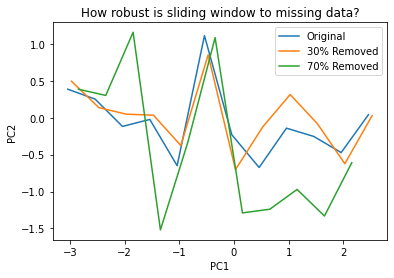

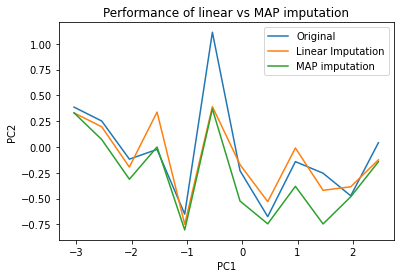

In [24]:
import matplotlib.pyplot as plt 
import pandas as pd 

# Graph out rolling windows 
df_missing_30 = artificially_remove_data(df, 0.3) 
df_missing_70 = artificially_remove_data(df, 0.7) 

def sliding_window(points, window, label):
    min_x = min(points[:,0])
    max_x = max(points[:,0])
    Y = [] 
    X = np.arange(min_x, max_x, window)
    for x in X:
        Y += [np.mean(points[(points[:,0] < x + window/2) & (points[:,0] > x - window/2) & ~np.isnan(points[:,1]), 1])]
    plt.plot(X,Y, label=label)

plt.figure()
sliding_window(df[:,1:], 0.5, 'Original')
sliding_window(df_missing_30[:,1:], 0.5, '30% Removed')
sliding_window(df_missing_70[:,1:], 0.5, '70% Removed')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('How robust is sliding window to missing data?')
plt.legend()
plt.show() 

plt.figure()
sliding_window(df[:,1:], 0.5, 'Original')
sliding_window(df_imputed_linear[:,1:], 0.5, 'Linear Imputation')
sliding_window(df_imputed_MAP[:,1:], 0.5, 'MAP imputation')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Performance of linear vs MAP imputation')
plt.legend()
plt.show() 
    

